# Quantum Phase Estimation for Solving Matrix Eigenvalues

Quantum Phase Estimation (QPE) is a key algorithm in quantum computing, allowing you to estimate the eigenphase of a unitary matirx (or the eigenvalue of a Hermitian matrix). The algorithm is designed such that given the inputs of a Hermitian matrix $M$ and an eigenvector ${|\psi\rangle}$, the output obtained is $\theta$, where

$ U{|\psi\rangle} = e^{2\pi i\theta}{|\psi\rangle} , U = e^{2\pi iM} $.

By measuring the accumulated phase, the QPE algorithm calculates the eigenvalues relating to the chosen input vector. To read more about the QPE algorithm and its method for achieving the phase, refer to [[1](#NC)].

Generally speaking, when the eigenvectors of the matrix are not known in advance yet the eigenvalues are sought, you can choose a random vector ${|v\rangle}$ for the algorithm’s initial state. Some eigenvalues will be found as the vector can be described in the matrix's basis, defined by the set of eigenvalues of $M$: {$\psi_i$}. Generally, any vector can be written as a superposition of any basis set, thus

${|v\rangle} = \sum_i a_i{|\psi_i\rangle}$

and

$U{|v\rangle} = \sum_i a_i e^{2\pi i\theta_i}{|\psi_i\rangle}$.

Using execution with enough shots, you can obtain this set of $\theta_i$; i.e., a subset of the matrix's eigenvalues.

**This tutorial presents a generic usage of the QPE algorithm:**

1. Define classical and quantum functions for constructing the algorithm.

2. Take a specific example, a matrix and some initial state.

3. Choose a resolution for the solution.

4. Find the related eigenvalues using QPE and analyze the results.

In [1]:
import math

import numpy as np

from classiq import *

## Classical functions

### Matrix rescaling

As QPE obtains a phase in the form $e^{2\pi i\theta}$, there is meaning only for $\theta \in [-1/2,1/2)$. However, the matrix $M$ can have any eigenvalue. To fix this discrepancy, the values of the matrix are rescaled. If
$\theta \in [\lambda_{min}, \lambda_{max}]$ you can use a normalization function to map those values into $[-1/2, 1/2)$.

Perform the normalization procedure by:

a. Defining the function `get_normalization` that finds a rough estimation for the eigenvalue with the largest absolute value. This yields a value $\bar{\lambda} = {\max}\left\{|\lambda_\max|,|\lambda_\min|\right\}$, such that you can assume $\theta \in [-\bar{\lambda}, \bar{\lambda}]$.

b. Defining the function `normalize_hamiltonian` that normalizes by $2\bar{\lambda}$ the Hamiltonian, and thus its eigenvalues, such that the evaluated span is then $\theta\in [-1/2, 1/2]$.

(Note that in this case $\theta=\pm1/2$ correspond to the same phase, however, this is an edge case where the normalized Hamiltonian has exactly those two eigenvalues. To avoid this, you can apply an extra factor of $(1-1/2^m)$, where $m$ is the size of the phase variable).

In [2]:
def get_normalization(hamiltonian):
    """
    Bounds the eigenvalue with the maximal absolute value by summing all the absolute values of the Pauli coefficients
    """
    abs_coeff = np.abs([term.coefficient for term in hamiltonian.terms])
    return 2 * sum(abs_coeff)


def normalize_hamiltonian(hamiltonian, normalization_coeff):
    return hamiltonian * (1 / normalization_coeff)

### QPE precision estimator

For QPE algorithms, the precision is set by phase register size $m$, such that the resolution is $1/{2^m}$. If the matrix needs to be normalized, the resolution will be distorted. In the case of normalization, the span of results for the QPE stretches between the lowest and highest possible phase, thus the resolution is mapped to $\sim 1/{((\lambda_{max}-\lambda_{min})*2^m)}$.

In [3]:
def get_qpe_precision(hamiltonian, desired_resolution):
    nqpe = math.log2(get_normalization(hamiltonian) / desired_resolution)
    return math.ceil(nqpe)

## Quantum functions

Use the built-in `qpe_flexible` function, which allows you to prescribe the "telescopic" expansion of the powered unitary via the `unitary_with_power` "QCallable" (see [Flexible QPE tutorial](https://docs.classiq.io/latest/tutorials/tutorials/high-level-modeling-flexible-qpe/high-level-modeling-flexible-qpe/ )). Define two examples for the powered unitary:


### Approximated evolution: A first order Suzuki Trotter with power-logic

Wrap the Trotter-Suzuki function of order 2 with a "power-logic" for the repetition as a function of its power.

In [4]:
from classiq.qmod.symbolic import ceiling, log


@qfunc
def suzuki_trotter2_with_power_logic(
    hamiltonian: SparsePauliOp,
    pw: CInt,
    r0: CInt,
    reps_scaling_factor: CReal,
    evolution_coefficient: CReal,
    target: QArray,
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=2,
        repetitions=ceiling(r0 * reps_scaling_factor ** (log(pw, 2))),
        qbv=target,
    )

## Setting a specific example

### Set the matrix

Define the matrix to submit. This can be any Hermitian matrix with size $2^n$ by $2^n$ with $n$ a positive integer. Throughout the code this matrix is given in the variable `M`.

In [5]:
M = np.array(
    [
        [0.38891555, 0.23315811, 0.21499372, 0.06119557],
        [0.23315811, 0.44435328, 0.25197881, -0.13087919],
        [0.21499372, 0.25197881, 0.44116509, -0.01961855],
        [0.06119557, -0.13087919, -0.01961855, 0.32556608],
    ]
)

M = (M + M.transpose()) / 2

### Set the initial vector 

Choose the vector that will be defined later as the initial condition for the run. There are two options: (1) define a random initial vector, or (2) choose some eigenvector of the matrix. For the demonstration, proceed with the first option:

In [6]:
np.random.seed(8)
int_vec = np.random.rand(np.shape(M)[0])

print("Your initial state is", int_vec)

Your initial state is [0.8734294  0.96854066 0.86919454 0.53085569]


### Preparing the matrix for QPE

In [7]:
hamiltonian = matrix_to_pauli_operator(M)

In [8]:
N = hamiltonian.num_qubits
print("number of qubits: ", N)

number of qubits:  2


#### Choose the algorithm's precision

Choose the precision using the `n_qpe` parameter or set your desired resolution.

In [9]:
desired_resolution = 0.02
n_qpe = get_qpe_precision(hamiltonian, desired_resolution)

print("number of qubits for QPE is", n_qpe)

number of qubits for QPE is 7


#### Normalize the matrix

Transform the matrix to ensure its eigenvalues are between $-1/2$ to $1/2$. The QPE procedure is performed on the new normalized matrix. After the phases are obtained, gather the original phases of the pre-normalized matrix by performing opposite steps to this normalization procedure.

In [10]:
normalization_coeff = get_normalization(hamiltonian)
new_hamiltonian = normalize_hamiltonian(hamiltonian, normalization_coeff)
Mnew = M / normalization_coeff

## Building the quantum model

Create a quantum model of the QPE algorithm using the Classiq platform with your desired constraints and preferences.
Run two different models, with a unitary implementation, which is exact; or with an approximated prodcut formula. Synthesize the models and compare the resulting quantum programs. The exact version is a non-scalable approach, but a convenient one for small usecases.

In [11]:
import scipy

my_amp = (
    int_vec / np.linalg.norm(int_vec)
).tolist()  # amplitude is given by the eignevector


@qfunc
def main(phase_result: Output[QNum[n_qpe, SIGNED, n_qpe]]) -> None:
    state = QArray()
    prepare_amplitudes(my_amp, 0.0, state)
    allocate(phase_result)
    qpe_flexible(
        unitary_with_power=lambda pw: power(
            pw,
            lambda: unitary(
                elements=scipy.linalg.expm(1j * 2 * np.pi * Mnew).tolist(), target=state
            ),
        ),
        phase=phase_result,
    )


write_qmod(main, "qpe_for_matrix_exact", decimal_precision=15)
qprog_exact = synthesize(main)


@qfunc
def main(phase_result: Output[QNum[n_qpe, SIGNED, n_qpe]]) -> None:
    state = QArray()
    prepare_amplitudes(my_amp, 0.0, state)
    allocate(phase_result)
    qpe_flexible(
        unitary_with_power=lambda pw: suzuki_trotter2_with_power_logic(
            hamiltonian=new_hamiltonian,
            pw=pw,
            r0=2,
            reps_scaling_factor=1.5,
            evolution_coefficient=-2 * np.pi,
            target=state,
        ),
        phase=phase_result,
    )


write_qmod(main, "qpe_for_matrix_approx", decimal_precision=15)
qprog_approx = synthesize(main)

In [12]:
print(
    f"Depth for QPE with exact Hamiltonian evolution: {qprog_exact.transpiled_circuit.depth}"
)
print(
    f"Depth for QPE with approximated Hamiltonian evolution: {qprog_approx.transpiled_circuit.depth}"
)

Depth for QPE with exact Hamiltonian evolution: 384
Depth for QPE with approximated Hamiltonian evolution: 26311


As expected, for this small usecase the exact evolution yeilds better results.

Display it with the analyzer:

In [13]:
show(qprog_exact)

Quantum program link: https://platform.classiq.io/circuit/30dWSAgCcAYFIEToV05xLjQgOQx


## Measuring and analyzing the results

Execute the quantum programs and analyze the results, in comparison to the expected classical ones.

### Execute the quantum program 

Send the quantum programs for execution by a chosen backend and print the raw results.

In [14]:
num_shots = 10000
execution_prefs = ExecutionPreferences(num_shots=num_shots)
with ExecutionSession(qprog_exact, execution_prefs) as es:
    result_exact = es.sample()
with ExecutionSession(qprog_approx, execution_prefs) as es:
    result_approx = es.sample()

df_exact = result_exact.dataframe
df_approx = result_approx.dataframe

Choose the number of eigenvalues to extract from the pool of results. The `number_of_solutions` value determines how many results are analyzed. Get the solution by multiplying back the normalization coefficient.

In [15]:
number_of_solutions = 2  # number of phases sought

In [16]:
solution_exact = list(df_exact.phase_result[:number_of_solutions] * normalization_coeff)
solution_approx = list(
    df_approx.phase_result[:number_of_solutions] * normalization_coeff
)

These are the results, including the error contributed from the resolution (the number of qubits participating in the QPE):

In [17]:
print(
    f"Your {number_of_solutions} solutions with the highest probability are:\n {solution_exact} (exact) \n {solution_approx} (approx)"
)

energy_resolution = (1 / (2**n_qpe)) * 2 * normalization_coeff
print("the resolution of results is", energy_resolution)
print("=" * 15 + " exact " + "=" * 15)

for sol in solution_exact:
    print(
        "the solutions are between",
        sol - energy_resolution,
        "and",
        sol + energy_resolution,
    )

print("=" * 15 + " approximated " + "=" * 15)
for sol in solution_approx:
    print(
        "the solutions are between",
        sol - energy_resolution,
        "and",
        sol + energy_resolution,
    )

Your 2 solutions with the highest probability are:
 [0.8992759912499999, 0.40375656749999994] (exact) 
 [0.8809234199999999, 0.9176285624999999] (approx)
the resolution of results is 0.036705142499999996
=============== exact ===============
the solutions are between 0.8625708487499999 and 0.9359811337499999
the solutions are between 0.36705142499999993 and 0.44046170999999995
=============== approximated ===============
the solutions are between 0.8442182774999999 and 0.9176285624999999
the solutions are between 0.8809234199999999 and 0.9543337049999999


### Plot the solution's histogram and compare to classical results

In [18]:
w, v = np.linalg.eig(M)
print("the eigenvalues are", w)

the eigenvalues are [0.9 0.4 0.1 0.2]


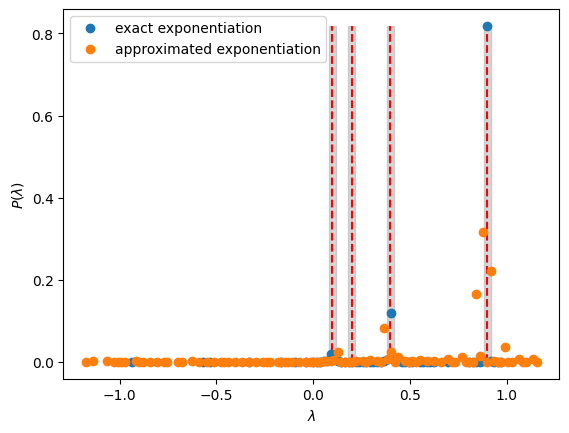

In [19]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

width = energy_resolution

for eig in w:
    # Add gray rectangle
    rect = patches.Rectangle(
        (eig - width / 2, 0), width, df_exact.probability[0], color="gray", alpha=0.3
    )
    plt.gca().add_patch(rect)

    # Plot vertical line
    plt.plot([eig, eig], [0, df_exact.probability[0]], "--r")


(exact,) = plt.plot(
    df_exact.phase_result * normalization_coeff,
    df_exact.probability,
    "o",
    label="exact exponentiation",
)
(approx,) = plt.plot(
    df_approx.phase_result * normalization_coeff,
    df_approx.probability,
    "o",
    label="approximated exponentiation",
)
plt.legend(handles=[exact, approx])
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$P(\lambda)$");

## References

<a name='NC'>[1]</a>: [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, New York, NY, USA.
](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition)
